In [4]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

**Informacije o podacima:**
Ovaj skup podataka sadrži preko 65 hiljada zapisa o prekršajima u saobraćaju.

Podaci o atributima:
1. stop_date - Datum prekršaja
2. stop_time - Vreme prekršaja
3. driver_gender - Pol prekršioca (Muško-M, Žensko-F)
4. driver_age - Godine prekršioca
5. driver_race - Rasa prekršioca
6. violation - Vrsta prekršaja :
    - Speeding 
    - Moving Violation (Neoprezna vožnja, Hit and run, Ugrožavanje ostalih vozača i pešaka, neoprezna skretanja i promena trake...)
    - Equipment (Zatamljena stakla, Neispravni farovi, Napukli vetrobran, etc.)
    - Registration/Plates
    - Seat Belt
    - other
7. search_conducted - Da li je došlo do pretresa nakon prekršaja
8. stop_outcome - Rezultat policijske intervencije
9. is_arrested - Da li je prekrsilac uhapšen ili ne
10. stop_duration - Vreme provedeno tokom intervencije
11. drugs_related_stop - Da li je prekršilac bio pod uticajem alkohola i opojnih droga

# Učitavanje i analiza skupa podataka

In [15]:
df = pd.read_csv('../dataset/traffic_violations.csv')
rows, columns = df.shape
print(f'Broj redova: {rows}')
print(f'Broj kolona: {columns}')
print(f'Imena atributa: {list(df.columns)}')
df.head()

Broj redova: 52966
Broj kolona: 15
Imena atributa: ['stop_date', 'stop_time', 'country_name', 'driver_gender', 'driver_age_raw', 'driver_age', 'driver_race', 'violation_raw', 'violation', 'search_conducted', 'search_type', 'stop_outcome', 'is_arrested', 'stop_duration', 'drugs_related_stop']


,stop_date,stop_time,country_name,driver_gender,driver_age_raw,driver_age,driver_race,violation_raw,violation,search_conducted,search_type,stop_outcome,is_arrested,stop_duration,drugs_related_stop
0,1/2/2005,1:55,NaN,M,1985.0,20.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
1,1/18/2005,8:15,NaN,M,1965.0,40.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
2,1/23/2005,23:15,NaN,M,1972.0,33.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
3,2/20/2005,17:15,NaN,M,1986.0,19.0,White,Call for Service,Other,False,NaN,Arrest Driver,True,16-30 Min,False
4,3/14/2005,10:00,NaN,F,1984.0,21.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False


Atributi driver_age_raw i driver_age govore istu stvar, pa ćemo izbaciti atribut driver_age.

In [18]:
df.drop('driver_age_raw', axis=1, inplace=True)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52966 entries, 0 to 52965
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   stop_date           52966 non-null  object 
 1   stop_time           52965 non-null  object 
 2   country_name        0 non-null      float64
 3   driver_gender       49580 non-null  object 
 4   driver_age          49346 non-null  float64
 5   driver_race         49581 non-null  object 
 6   violation_raw       49581 non-null  object 
 7   violation           49581 non-null  object 
 8   search_conducted    52965 non-null  object 
 9   search_type         2085 non-null   object 
 10  stop_outcome        49581 non-null  object 
 11  is_arrested         49581 non-null  object 
 12  stop_duration       49581 non-null  object 
 13  drugs_related_stop  52965 non-null  object 
dtypes: float64(2), object(12)
memory usage: 5.7+ MB


# Rad sa nedostajućim vrednostima

Proveravamo da li u skupu postoje nedostajuće vrednosti

In [20]:
df.isna().any().any()

True

U skupu postoje nedostajuće vrednosti. Koliko ih ima?

In [21]:
df.isna().sum()

stop_date                 0
stop_time                 1
country_name          52966
driver_gender          3386
driver_age             3620
driver_race            3385
violation_raw          3385
violation              3385
search_conducted          1
search_type           50881
stop_outcome           3385
is_arrested            3385
stop_duration          3385
drugs_related_stop        1
dtype: int64

## Izbacivanje nedostajućih vrednosti

**Atributi country_name i search_type sadrže skoro sve NaN vrednosti, pa ćemo ih izbaciti**

Ostali atributi imaju sličnu reprezentaciju podataka, pa ćemo eliminisati redove koje sadrže nedostajuće vrednosti.

In [22]:
df1 = df.copy(deep=True)
df1.drop(columns = ['country_name','search_type'], inplace=True)
df1.dropna(subset = ['driver_gender'], inplace = True)

In [23]:
df1.isna().sum()

stop_date               0
stop_time               0
driver_gender           0
driver_age            240
driver_race             0
violation_raw           0
violation               0
search_conducted        0
stop_outcome            0
is_arrested             0
stop_duration           0
drugs_related_stop      0
dtype: int64

U atributu driver_age postoje nedostajuće vrednosti. Popunićemo ih sa medijanom.

Nakon obrade, proveravamo da li je ostalo nedostajućih vrednosti.

In [25]:
df2 = df1.copy(deep=True)
df2['driver_age'] = df2['driver_age'].fillna(df.groupby('driver_gender')['driver_age'].transform('median'))
df2.isna().any().any()

False

Sada smo spremni za dalju analizu.

In [26]:
data = df2.copy(deep=True)
pd.to_datetime(data['stop_time'])
data['stop_hour'] = pd.to_datetime(data['stop_time'], format = '%H:%M').dt.hour

data['stop_duration'].value_counts()
data['stop_duration'] = data['stop_duration'].map({'0-15 Min':7.5,'16-30 Min':23,'30+ Min':45})
stop_duration_based_on_race = data.groupby('driver_race')[['stop_duration']].mean()

data.search_conducted = data.search_conducted.replace(to_replace=[True, False], value=[1, 0])
data.drugs_related_stop = data.drugs_related_stop.replace(to_replace=[True, False], value=[1, 0])
data['stop_date'] = pd.to_datetime(data['stop_date'])
data['stop_Year'] = pd.DatetimeIndex(data['stop_date']).year
yearly_data = data.groupby('stop_Year').sum()
yearly_data.reset_index(inplace = True)

search_conducted = len(data[data.search_conducted == True])
arrested_after_search = len(data[(data.search_conducted == True) & (data.is_arrested == True)])
arrested = ((arrested_after_search/search_conducted)*100)
not_arrested = (100-(arrested))

C:\Users\Stefan\AppData\Local\Temp\ipykernel_9992\132031109.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  yearly_data = data.groupby('stop_Year').sum()


In [27]:
data.head()

,stop_date,stop_time,driver_gender,driver_age,driver_race,violation_raw,violation,search_conducted,stop_outcome,is_arrested,stop_duration,drugs_related_stop,stop_hour,stop_Year
0,2005-01-02,1:55,M,20.0,White,Speeding,Speeding,0,Citation,False,7.5,0,1,2005
1,2005-01-18,8:15,M,40.0,White,Speeding,Speeding,0,Citation,False,7.5,0,8,2005
2,2005-01-23,23:15,M,33.0,White,Speeding,Speeding,0,Citation,False,7.5,0,23,2005
3,2005-02-20,17:15,M,19.0,White,Call for Service,Other,0,Arrest Driver,True,23.0,0,17,2005
4,2005-03-14,10:00,F,21.0,White,Speeding,Speeding,0,Citation,False,7.5,0,10,2005


 ## Raspodela godina

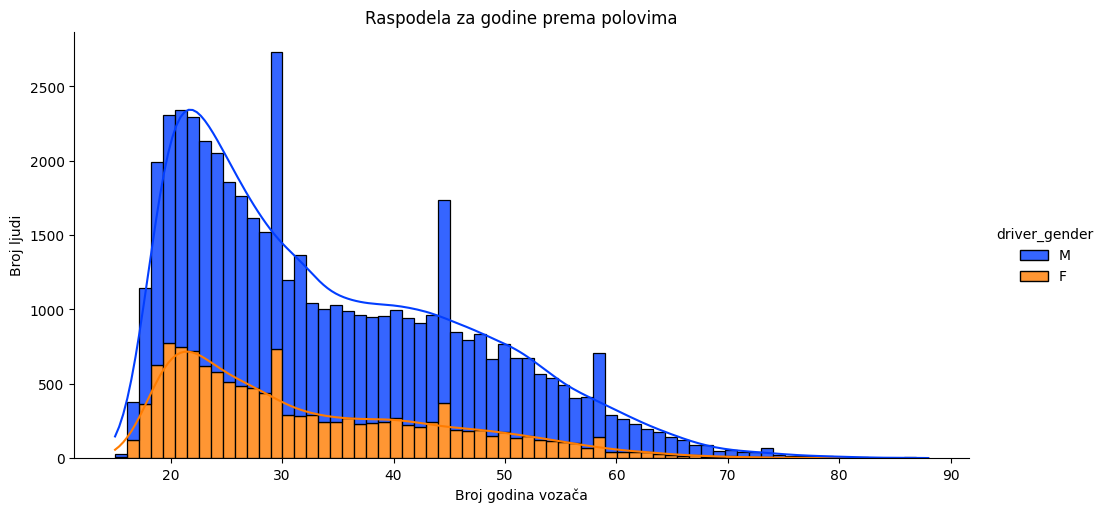

In [28]:
sns.displot(x = 'driver_age', hue = 'driver_gender', kde = True, data = data, 
            multiple = 'stack', alpha = 0.8, palette = "bright", height=5, aspect=2)
plt.title('Raspodela za godine prema polovima')
plt.xlabel("Broj godina vozača")
plt.ylabel("Broj ljudi");

Možemo primetiti da i muški i ženski vozači starosti između 20 i 40 godina čine maksimalne prekršaje, dok ih oni stariji od 16 godina čine minimalno. Takodje, vidimo da trend prekršaja i starosne grupe za jednu polnu grupu sledi iz druge. 

To znaci da su prekršaji nezavisni od pola osobe, što je i očigledno imajući u vidu sve ostale parametre.

## Raspodela tipa prekršaja

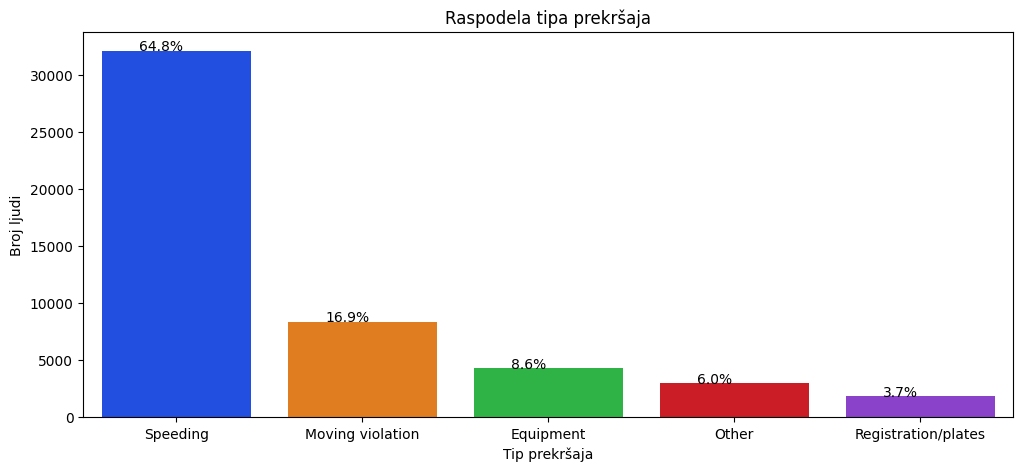

In [29]:
fig , ax = plt.subplots(figsize=(12,5))
ax = sns.countplot(x = data.violation, data = data, order = data.violation.value_counts().index, palette = "bright")
for i in ax.patches:
    percentage = '{:.1f}%'.format(100*i.get_height()/len(data.violation))
    x = i.get_x()+i.get_width()-0.6
    y = i.get_height()
    ax.annotate(percentage, (x, y))
plt.title("Raspodela tipa prekršaja")
plt.xlabel("Tip prekršaja")
plt.ylabel("Broj ljudi");

**Ubedljivo, prekršaji u saobraćaju, prema datom skupu podataka, najviše nastaju zbog prekoračenja dozvoljene brzine. Čak 64.8% od svih ostalih razloga zbog kojeg je nastao prekršaj.**

## Vreme nastanka prekršaja

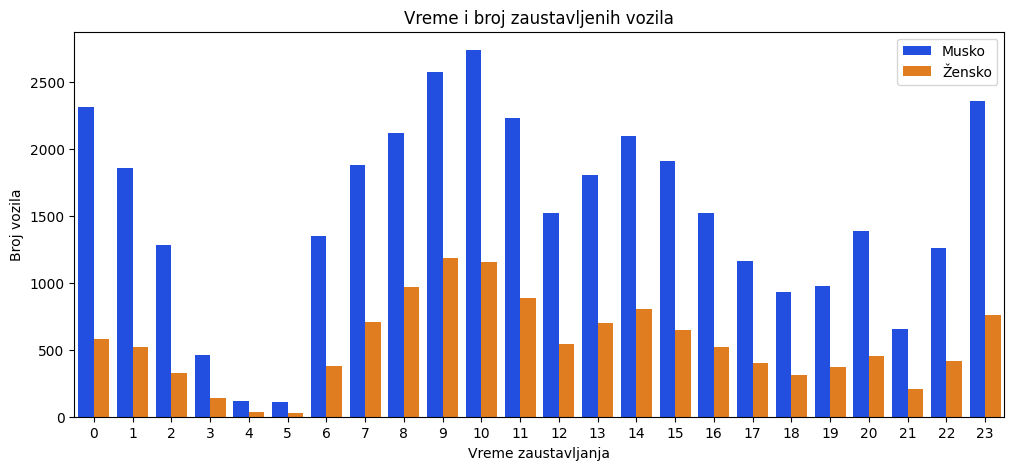

In [31]:
plt.figure(figsize = (12,5))
sns.countplot(x = data.stop_hour,data = data,hue = 'driver_gender', palette = "bright")
plt.title('Vreme i broj zaustavljenih vozila')
plt.legend(['Musko','Žensko'])
plt.xlabel("Vreme zaustavljanja")
plt.ylabel("Broj vozila");

Sa grafika vidimo da se najviše učestali prekršaji, nastali usled prekomerne brzine, dešavaju između 08:00 i 16:00 časova, dok se nešto ređe dešavaju u večernjim satima i rano ujutru. Medjutim, od 22:00 do 02:00 časa ujutru dolazi do velikog broja prekršaja! Objašnjenje za ovo može biti da se ljudi vraćaju kući ili putuju na žurke, proslave itd.

Očigledno je da ljudi krše saobraćajna pravila iz više razloga, bilo da je u pitanju žurba, nedovoljne veštine vožnje itd.  Još jedno važno zapažanje može biti najviše od svih (u proseku) prekršaja između 8:00 i 15:00 časova. Mogućnost za ovo može biti tipično radno vreme javnosti tokom ovih sati, i da se u ovom slučaju mogu pojaviti brojne situacije za „prekoračenje brzine“.

Konačno, za sve sate u danu, žene su uvek imale mnogo manje slučajeva prekršaja od muškaraca. Za ovo može biti mnogo mogućnosti, neke od njih su da ima manje ženskih vozača nego muških vozača, ili da se gore predložene mogućnosti ne prate za oba pola.

## Raspodela prekršaja u odnosu na rasu

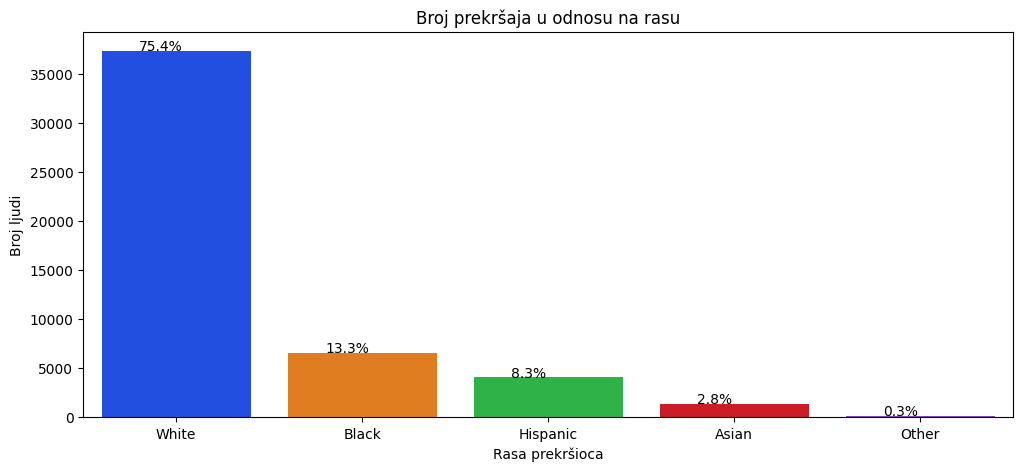

In [32]:
fig , ax = plt.subplots(figsize = (12,5))
ax = sns.countplot(x=data.driver_race, data=data, order = data.driver_race.value_counts().index,
                   linewidth = 0, palette = "bright")
for i in ax.patches:
    percentage = '{:.1f}%'.format(100*i.get_height()/len(data.driver_race))
    x = i.get_x()+i.get_width()-0.6
    y = i.get_height()
    ax.annotate(percentage, (x, y))
plt.title('Broj prekršaja u odnosu na rasu')
plt.xlabel("Rasa prekršioca")
plt.ylabel("Broj ljudi");

Razvrstavajući ukupne prekršaje u rasu prekršitelja, iz grafika vidimo da belci, crnci i hispanici zajedno doprinose oko 97% ukupnih prekršaja. Među njima ljudi bele rase krše najviše sa učešćem od 74,4% ukupno. 

Vrlo očigledan razlog za ovo može biti raspodela stanovništva među različitim rasama ljudi, tj. pošto ima najviše belih, bilo koji skup podataka je sklon da ima više zapažanja za prekršaje iz ove kategorije. Iako, mora se imati na umu da može biti i više drugih razloga za ovaj trend.

## Starosne grupe korisnika opojnih supstanci

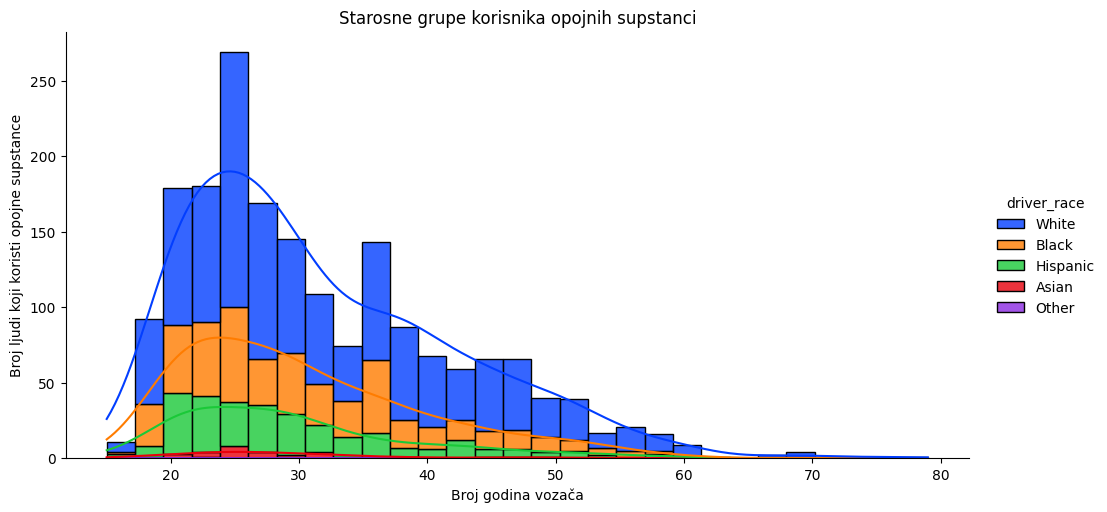

In [33]:
sns.displot(x='driver_age',data = data[data['is_arrested']==True],
            kde = True, hue = 'driver_race', multiple = "stack", alpha = 0.8, palette = "bright", height=5, aspect=2)
plt.title('Starosne grupe korisnika opojnih supstanci')
plt.xlabel("Broj godina vozača")
plt.ylabel("Broj ljudi koji koristi opojne supstance");

Za ljude u dvadesetim godinama, tj. starosne grupe između 20–30 godina, primećeno je da su mnogo više uključeni u konzumiranje droga i opojnih supstanci nego oni iz bilo koje druge starosne grupe. 

Ovo takođe daje težinu činjenici da su „droge“ važan element jednačine i da se moraju uzeti u obzir za predviđanje saobraćajnih prekršaja.

## Trajanje policijske intervencije u odnosu na rasu prekršioca

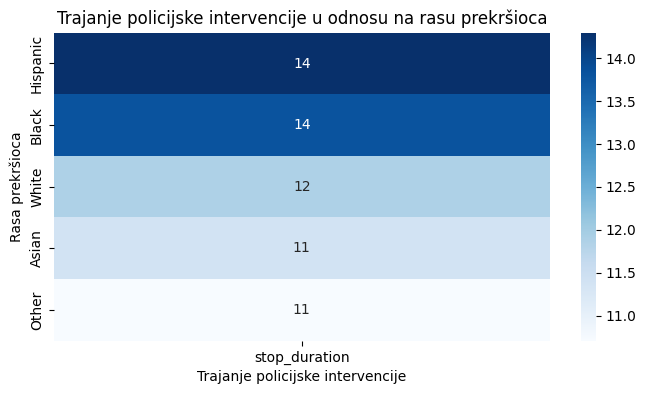

In [35]:
plt.figure(figsize = (8,4))
sns.heatmap(stop_duration_based_on_race.sort_values(by = ['stop_duration'], ascending=False), annot = True, cmap = "Blues");
plt.title("Trajanje policijske intervencije u odnosu na rasu prekršioca")
plt.xlabel("Trajanje policijske intervencije")
plt.ylabel("Rasa prekršioca");

Ovo mapiranje čini prilično očiglednim da se ljudi sa hispanskim i/ili crnim rasnim poreklom najviše zaustavljaju nego bilo koja druga rasa. Drugo, prilično je iznenađujuće da iako su belci zabeležili da najviše krše saobraćajna pravila; oni nisu zaustavljeni dovoljno u poređenju.

## Toplotna mapa korelacije

C:\Users\Stefan\AppData\Local\Temp\ipykernel_9992\4021313584.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  result = data.groupby('violation')[['search_conducted','drugs_related_stop','is_arrested']].sum()


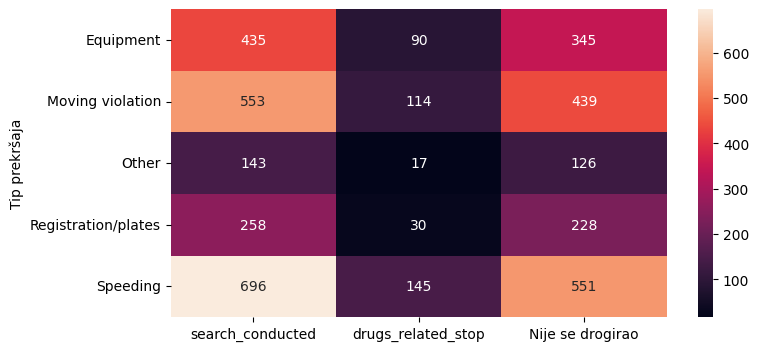

In [44]:
result = data.groupby('violation')[['search_conducted','drugs_related_stop','is_arrested']].sum()
result['Nije se drogirao'] = result['search_conducted']-result['drugs_related_stop']
plt.figure(figsize = (8,4))
sns.heatmap(result, annot = True, fmt = ".0f");
plt.ylabel("Tip prekršaja");

Ova slika predstavlja zavisnost slučajeva zasnovanih na drogama sa pretragama koje su sprovedene za različite vrste vrsta prekršaja. Kao što se prati u svim vrstama prekršaja, većina ukupnih pretraga koje su sprovedene ne ispadaju da su od ljudi koji su uključeni u droge. 

Zanimljivo je primetiti da je ovaj odnos nezavisan od vrste saobraćajnog prekršaja koji je počinjen.

## Odnos ukupnog broja pretresa i pretres zbog korišćenja opojnih supstanci

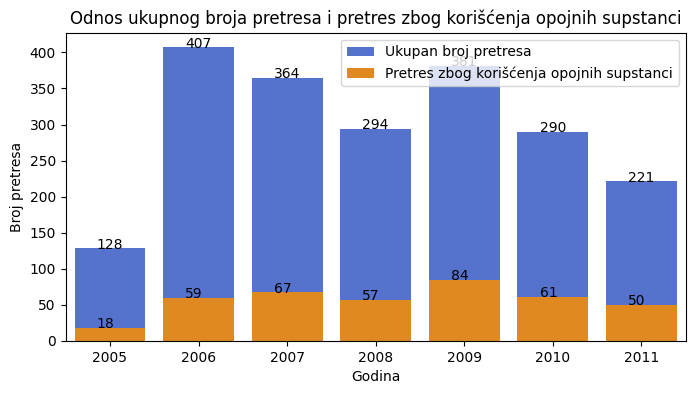

In [51]:
fig, ax = plt.subplots(figsize = (8,4))
sns.barplot(x = yearly_data.stop_Year, y = yearly_data.search_conducted,
            data = yearly_data,label = "Ukupan broj pretresa", color = "royalblue")
sns.barplot(x = yearly_data.stop_Year, y = yearly_data.drugs_related_stop,
            data = yearly_data,label = "Pretres zbog korišćenja opojnih supstanci", color = "darkorange")
for i in ax.patches:
    count = '{:,.0f}'.format(i.get_height())
    x = i.get_x()+i.get_width()-0.55
    y = i.get_height()
    ax.annotate(count, (x, y))
ax.set_title("Odnos ukupnog broja pretresa i pretres zbog korišćenja opojnih supstanci")
ax.set(xlabel = "Godina", ylabel = "Broj pretresa")
ax.legend(fontsize = '10');

Ovaj grafik prati sličan trend kao i prethodni, jedina razlika je u parametrima na X osi (Vreme zaustavljanja i godina zaustavljanja)

## Da li su prekršioci bili ranije uhapšeni

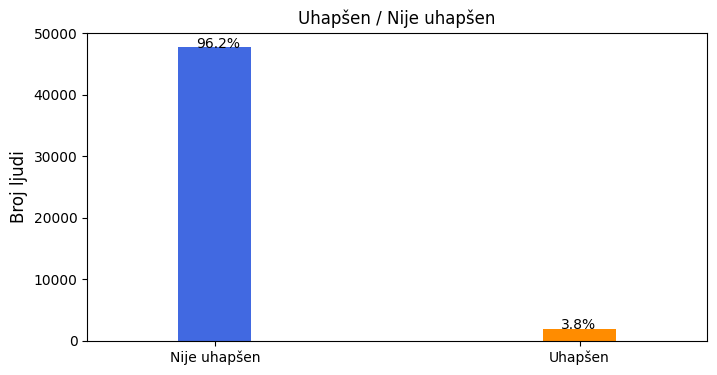

In [58]:
fig, ax = plt.subplots()
fig.canvas.draw()
data.is_arrested.value_counts().plot(kind="bar", width=0.2, figsize=(8, 4), color = ["royalblue","darkorange"])
plt.ylabel("Broj ljudi", fontsize=12)
plt.title("Uhapšen / Nije uhapšen")
for i in ax.patches:
    percentage = '{:.1f}%'.format(100 * i.get_height()/len(data.is_arrested))
    x = i.get_x() + i.get_width() - 0.15
    y = i.get_height()
    ax.annotate(percentage, (x, y))
ax.set_xticklabels(["Nije uhapšen","Uhapšen"], rotation = 0);

Možemo videti da velika većina tj 96.2% vozača nije ranije bila osuđivana.

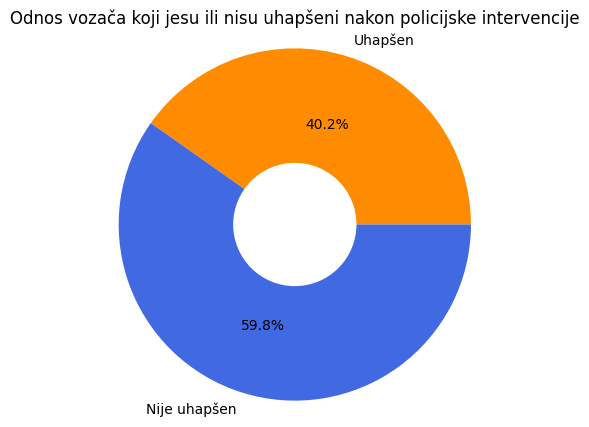

In [60]:
fig, ax = plt.subplots(figsize = (5,5))
ax.pie([arrested, not_arrested], labels = ('Uhapšen','Nije uhapšen'),
       autopct = '%1.1f%%', colors = ["darkorange","royalblue"])
centre_circle = plt.Circle((0,0), 0.35, fc = 'white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Odnos vozača koji jesu ili nisu uhapšeni nakon policijske intervencije');
ax.axis('equal');

Primećujemo da je oko 60% vozača prošlo nekažnjeno, a 40% vozača nije.